In [11]:
import pickle
import os
import numpy as np
import pandas as pd

In [1]:
1.4 / 32

0.04375

In [12]:
# load stats
# stats_path = os.path.abspath("out/2025-08-03_11:39:00/stats.pkl") # 2 robots, ~100 steps, no collisins
# stats_dir = "2025-08-03_13:57:29"
stats_path = 'stats.pkl'# stats_dir + "/stats.pkl" # 32 robots, ~100 steps, no collisins
with open(stats_path, 'rb') as f:
    stats = pickle.load(f)
task_type =  "CBSMP1"
n_agents = 32 # number of agents in the experiment
all_agents_step_time = 1.4 # measured in seconds during the experiment
agent_step_time = all_agents_step_time/n_agents


In [48]:
stats.keys()

dict_keys(['contact', 'goal_error', 'spheres'])

In [ ]:

df_spheres_raw = pd.DataFrame(stats['spheres'])
n_robots = len(df_spheres_raw[1][0])
n_spheres_per_robot = [len(df_spheres_raw[1][0][i]) for i in range(n_robots)]
r_index = [i for i in range(n_robots)]
s_index = [j for  j in range(max(n_spheres_per_robot))]












,tstep,tsec,agent,sphere,x,y,z,radius
0,0,0.00000,0,0,0.199951,-0.000000,0.0,0.026001
1,0,0.00000,0,1,0.199951,-0.000000,0.0,0.001100
2,0,0.00000,1,0,0.000000,0.199951,0.0,0.026001
3,0,0.00000,1,1,0.000000,0.199951,0.0,0.001100
4,0,0.00000,2,0,0.399902,-0.000000,0.0,0.026001
...,...,...,...,...,...,...,...,...
19323,903,39.50625,29,1,3.390625,2.998047,0.0,0.001100
19324,903,39.50625,30,0,3.199219,3.390625,0.0,0.026001
19325,903,39.50625,30,1,3.199219,3.390625,0.0,0.001100
19326,903,39.50625,31,0,3.390625,3.199219,0.0,0.026001


In [ ]:

ts_col = df_spheres_raw[0]
data_col = df_spheres_raw[1]
all_rows = [
    [int(ts_col[ts_idx]), # time step
     ts_col[ts_idx] * agent_step_time, # time in seconds
     a_idx, # agent index
     s_idx, # sphere index
     data_col[ts_idx][a_idx][s_idx][0],  # x
     data_col[ts_idx][a_idx][s_idx][1],  # y
     data_col[ts_idx][a_idx][s_idx][2],  # z
     data_col[ts_idx][a_idx][s_idx][3]]  # radius
    
    for ts_idx in range(len(ts_col)) 
    for a_idx in range(n_robots) 
    for s_idx in range(n_spheres_per_robot[a_idx]) 
]

df_spheres = pd.DataFrame(all_rows, columns=['tstep','tsec', 'agent', 'sphere', 'x', 'y', 'z', 'radius'])            
df_spheres

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



def plot_spheres_over_time(df_spheres, dims=3, color_by='tstep', cmap='viridis', scale_factor=90000,tick_colorbar=-1,time_focus=None,agent_focus=None,area_focus_x=None,area_focus_y=None,out_path=None):
    if dims in [2,3]:
        fig = plt.figure(figsize=(15, 10))
        if time_focus is not None:
            df_show = df_spheres[df_spheres['tstep'] >= time_focus[0]]
            df_show = df_show[df_show['tstep'] <= time_focus[1]]
        else:
            df_show = df_spheres

        if agent_focus is not None:
            df_show = df_show[df_show['agent'].isin(agent_focus)]
        
        if area_focus_x is not None:
            df_show = df_show[df_show['x'] >= area_focus_x[0]]
            df_show = df_show[df_show['x'] <= area_focus_x[1]]
        if area_focus_y is not None:
            df_show = df_show[df_show['y'] >= area_focus_y[0]]
            df_show = df_show[df_show['y'] <= area_focus_y[1]]
        
        if dims == 3:
            ax = fig.add_subplot(111, projection='3d')
            areas = np.pi * (df_show['radius'] ** 2) * scale_factor
            scatter = ax.scatter(df_show['x'], df_show['y'], df_show['z'], 
                            c=df_show[color_by], cmap=cmap, s=areas)
            
        elif dims == 2:
            ax = fig.add_subplot(111)
            areas = np.pi * (df_show['radius'] ** 2) * scale_factor
            scatter = ax.scatter(df_show['x'], df_show['y'], 
                            c=df_show[color_by], cmap=cmap, s=areas,alpha=0.3)
        
        
        # Connect lines between points within the same agent to 
        # better visualize the trajectory
        unique_values = sorted(df_show['agent'].unique())
        for value in unique_values:
            # Get data for this specific value, sorted by time
            value_data = df_show[df_show['agent'] == value].sort_values('tstep')
            
            if len(value_data) > 1:  # Only draw lines if there are at least 2 points
                if dims == 3:
                    ax.plot(value_data['x'], value_data['y'], value_data['z'],
                           color='black', alpha=0.3, linewidth=0.5)
                else:
                    ax.plot(value_data['x'], value_data['y'],
                           color='black', alpha=0.3, linewidth=0.5)
        
        
        ax.set_title('Robot Position Over Time')
        ax.set_xlabel('x (meters)')
        ax.set_ylabel('y (meters)')
        
        ticks = None # default ticks
        if tick_colorbar > 0: 
            tick_min = df_show[color_by].min()
            tick_max = df_show[color_by].max()
            ticks = np.arange(tick_min, tick_max,tick_colorbar)
        
        cbar = plt.colorbar(scatter, label=color_by,ticks=ticks)
        cbar.set_label(color_by)
        if out_path is not None:
            plt.savefig(out_path) 
        
    else:
        raise ValueError(f"Invalid dimensions: {dims}")



# cbsmp scenario 1

## 32 agents

### all steps

1. different colors = different time steps

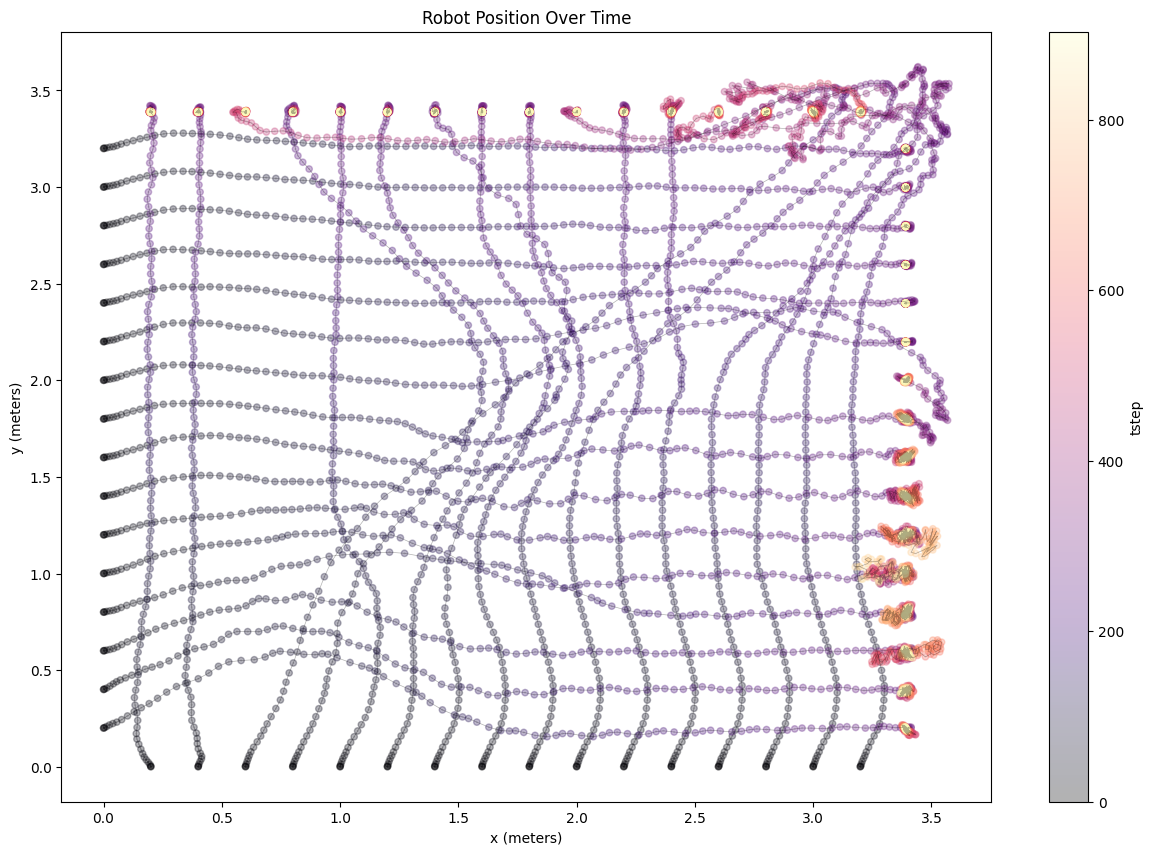

In [ ]:
plot_spheres_over_time(df_spheres,color_by='tstep', scale_factor=10000,cmap='magma',dims=2,out_path=f"{task_type}_{n_agents}_path_color_by_tstep.png") # https://matplotlib.org/stable/gallery/color/colormap_reference.html


2.different colors = different agents

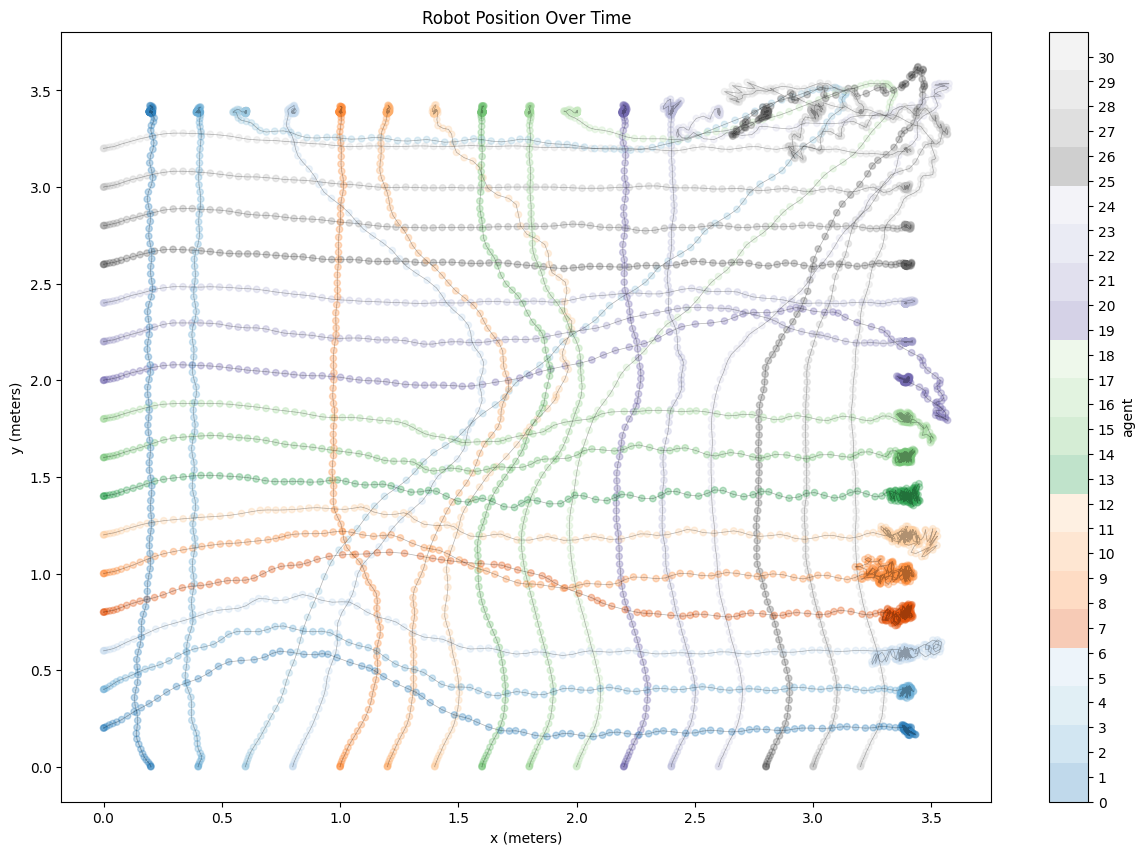

In [74]:
plot_spheres_over_time(df_spheres,color_by='agent', cmap='tab20c', dims=2, tick_colorbar=1,scale_factor=10000,out_path=f"{stats_dir}/conflict_focus_{task_type}_{n_agents}_path_color_by_agent.png") # https://matplotlib.org/stable/gallery/color/colormap_reference.html

### focusing only conflicts area (the interesting parts) 

In [75]:
time_focus = [100, 200] # None # [100,200]
agent_focus = list(range(6,20)) # None # list(range(4,15))
area_focus_x = None # [1.0,3.0] # [0.01,0.02]
area_focus_y = None # [1.0,3.0] # [0.01,0.02]

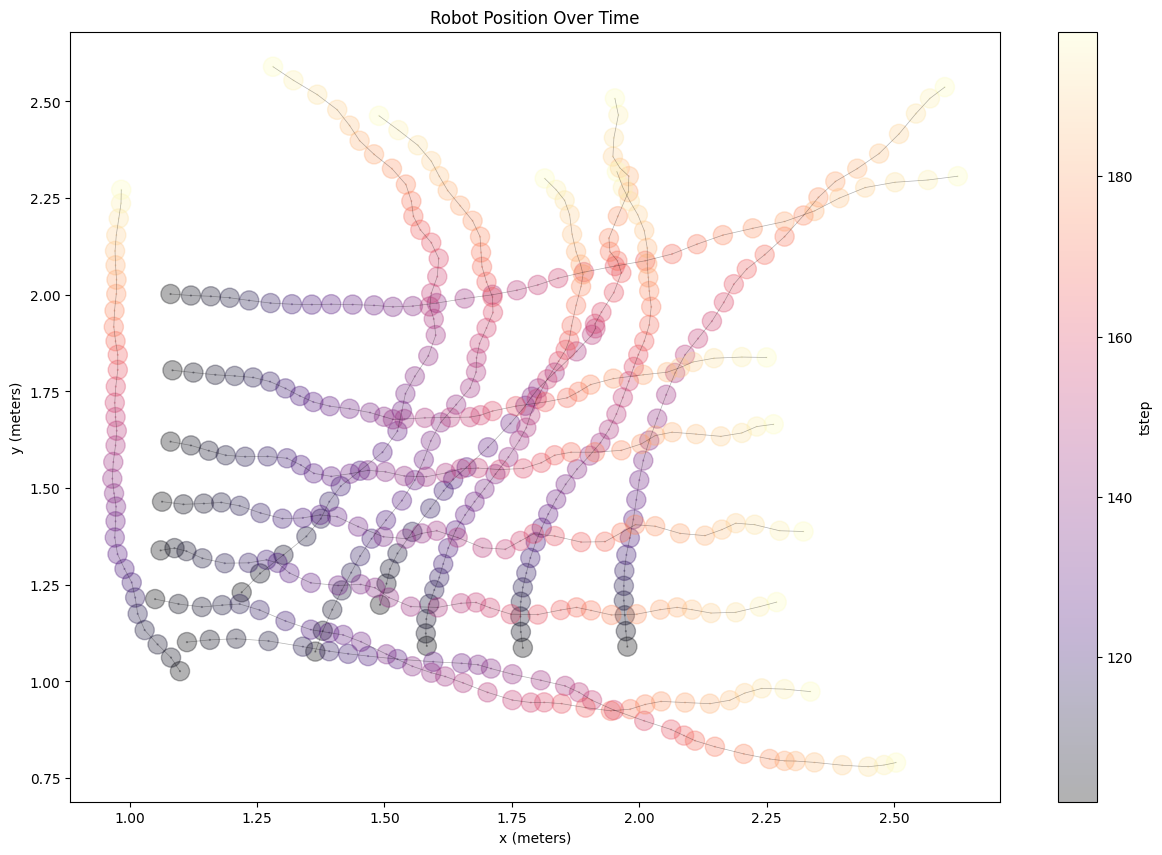

In [ ]:
plot_spheres_over_time(df_spheres,color_by='tstep' ,cmap='magma',dims=2,time_focus=agent_focus,agent_focus=agent_focus,area_focus_x=area_focus_x,area_focus_y=area_focus_y,out_path=f"{stats_dir}/conflict_focus_{task_type}_{n_agents}_path_color_by_tstep.png") # https://matplotlib.org/stable/gallery/color/colormap_reference.html


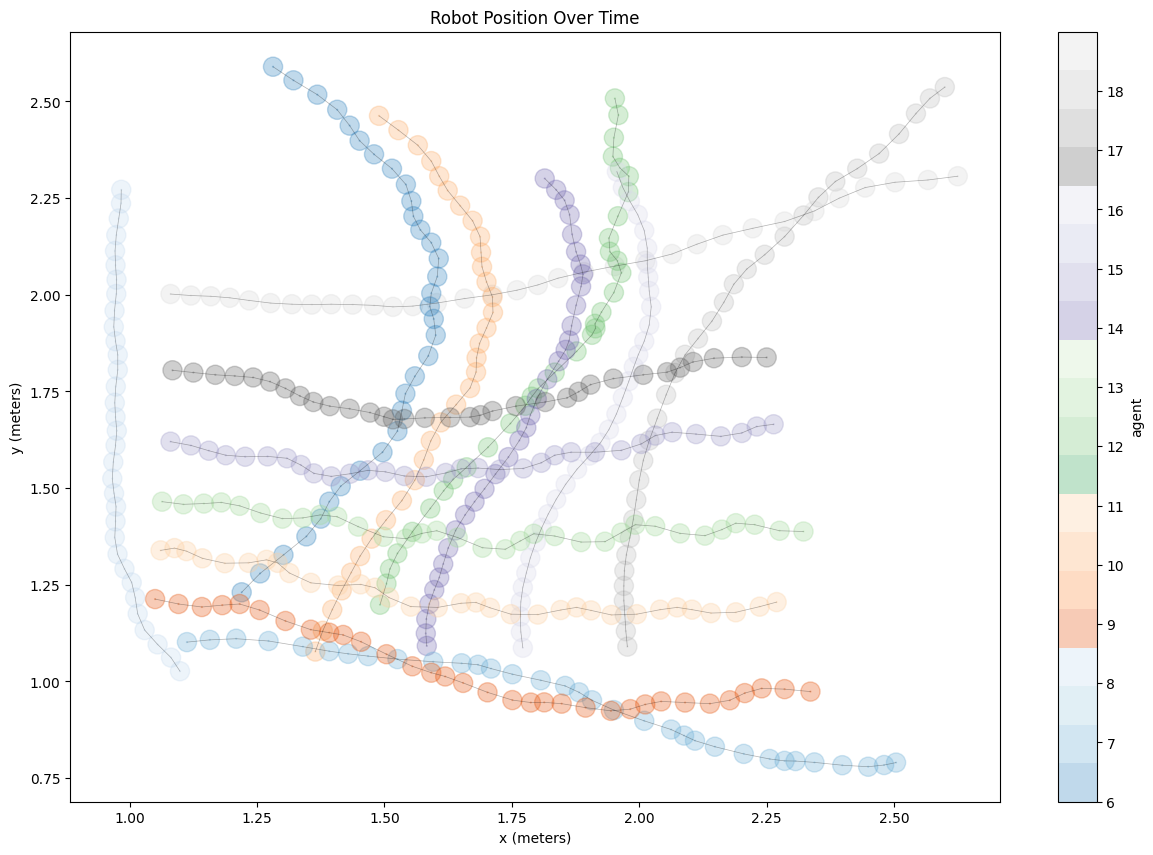

In [77]:
plot_spheres_over_time(df_spheres,color_by='agent', 
                       cmap='tab20c', 
                       dims=2, 
                       tick_colorbar=1,
                       time_focus=time_focus,
                       agent_focus=agent_focus,
                       area_focus_x=area_focus_x,
                       area_focus_y=area_focus_y,
                       out_path=f"{stats_dir}/conflict_focus_{task_type}_{n_agents}_path_color_by_agent.png") # https://matplotlib.org/stable/gallery/color/colormap_reference.html


# Goal error

In [ ]:
last = df_spheres[df_spheres['tstep'] == 903]
df_goals = last[['x','y','z','sphere']] # we had an error with logging goal poses so we get the goal poses from final pose (after confirming that the goal poses are the same as the final poses)

df_goals[df_goals['sphere'] == 0]













,x,y,z,sphere
19264,0.199463,3.388672,0.0,0
19266,3.388672,0.199097,0.0,0
19268,0.400635,3.388672,0.0,0
19270,3.373047,0.384277,0.0,0
19272,0.600098,3.388672,0.0,0
19274,3.400391,0.583496,0.0,0
19276,0.800293,3.388672,0.0,0
19278,3.402344,0.811523,0.0,0
19280,1.000000,3.388672,0.0,0
19282,3.390625,0.998535,0.0,0


In [ ]:
x_goal_start = 0.2
y_goal_start = 0.2
x_goal_end = 3.4
y_goal_end = 3.4

goals = []
x_current = x_goal_start
y_current = y_goal_start
for i in range(16):
    goals.append([x_current,y_goal_end,0])
    goals.append([x_goal_end,y_current,0])
    x_current += 0.2
    y_current += 0.2
    

ts_col = df_spheres_raw[0]
data_col = df_spheres_raw[1]
all_rows = [
    [
        int(ts_col[ts_idx]), # time step
        ts_col[ts_idx] * agent_step_time, # time in seconds
        a_idx, # agent index
        np.linalg.norm([data_col[ts_idx][a_idx][0][0]- goals[a_idx][0], data_col[ts_idx][a_idx][0][1]- goals[a_idx][1], data_col[ts_idx][a_idx][0][2]- goals[a_idx][2]]),  # radius
    ]
    
    for ts_idx in range(len(ts_col)) 
    for a_idx in range(n_robots) 
     
]

df_error = pd.DataFrame(all_rows, columns=['tstep','tsec', 'agent', 'pos_error'])            
df_error

,tstep,tsec,agent,pos_error
0,0,0.00000,0,3.400000
1,0,0.00000,1,3.400000
2,0,0.00000,2,3.400000
3,0,0.00000,3,3.400000
4,0,0.00000,4,3.400000
...,...,...,...,...
9659,903,39.50625,27,0.009882
9660,903,39.50625,28,0.011328
9661,903,39.50625,29,0.009576
9662,903,39.50625,30,0.009407


In [163]:
df_error.head

<bound method NDFrame.head of       tstep      tsec  agent  pos_error
0         0   0.00000      0   3.400000
1         0   0.00000      1   3.400000
2         0   0.00000      2   3.400000
3         0   0.00000      3   3.400000
4         0   0.00000      4   3.400000
...     ...       ...    ...        ...
9659    903  39.50625     27   0.009882
9660    903  39.50625     28   0.011328
9661    903  39.50625     29   0.009576
9662    903  39.50625     30   0.009407
9663    903  39.50625     31   0.009407

[9664 rows x 4 columns]>

In [ ]:

# Assuming your DataFrame is called 'df'
# If you have a different variable name, replace 'df' with your actual DataFrame name

def plot_pos_error_statistics(df):
    """
    Create a plot showing maximum, mean, and variance of pos_error over all agents for each tsec.
    
    Args:
        df: DataFrame with columns ['tstep', 'tsec', 'agent', 'pos_error']
    """
    
    # Group by tsec and calculate statistics
    stats = df.groupby('tsec').agg({
        'pos_error': ['max', 'mean', 'var']
    }).reset_index()
    
    # Flatten column names
    stats.columns = ['tsec', 'max_pos_error', 'mean_pos_error', 'var_pos_error']
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Plot each statistic
    plt.plot(stats['tsec'], stats['max_pos_error'], 'r-', linewidth=2, label='Maximum', alpha=0.8)
    plt.plot(stats['tsec'], stats['mean_pos_error'], 'b-', linewidth=2, label='Mean', alpha=0.8)
    plt.plot(stats['tsec'], stats['var_pos_error'], 'g-', linewidth=2, label='Variance', alpha=0.8)
    
    # Customize the plot
    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('Position Error', fontsize=12)
    plt.title('Position Error Statistics Over Time', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    
    # Add some styling
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    return stats

# Example usage:
# If your DataFrame is called 'df':
# stats = plot_pos_error_statistics(df)

# Alternative: If you want to save the plot
# def plot_pos_error_statistics_save(df, save_path='pos_error_statistics.png'):
#     """
#     Create and save a plot showing maximum, mean, and variance of pos_error over all agents for each tsec.
    
#     Args:
#         df: DataFrame with columns ['tstep', 'tsec', 'agent', 'pos_error']
#         save_path: Path to save the plot image
#     """
    
#     # Group by tsec and calculate statistics
#     stats = df.groupby('tsec').agg({
#         'pos_error': ['max', 'mean', 'var']
#     }).reset_index()
    
#     # Flatten column names
#     stats.columns = ['tsec', 'max_pos_error', 'mean_pos_error', 'var_pos_error']
    
#     # Create the plot
#     plt.figure(figsize=(12, 8))
    
#     # Plot each statistic
#     plt.plot(stats['tsec'], stats['max_pos_error'], 'r-', linewidth=2, label='Maximum', alpha=0.8)
#     plt.plot(stats['tsec'], stats['mean_pos_error'], 'b-', linewidth=2, label='Mean', alpha=0.8)
#     plt.plot(stats['tsec'], stats['var_pos_error'], 'g-', linewidth=2, label='Variance', alpha=0.8)
    
#     # Customize the plot
#     plt.xlabel('Time (seconds)', fontsize=12)
#     plt.ylabel('Position Error', fontsize=12)
#     plt.title('Position Error Statistics Over Time', fontsize=14, fontweight='bold')
#     plt.grid(True, alpha=0.3)
#     plt.legend(fontsize=11)
    
#     # Add some styling
#     plt.tight_layout()
    
#     # Save the plot
#     plt.savefig(save_path, dpi=300, bbox_inches='tight')
#     plt.close()
    
#     return stats

# If you want to create subplots for better visualization
def plot_pos_error_statistics_subplots(df):
    """
    Create subplots showing maximum, mean, and variance of pos_error separately.
    
    Args:
        df: DataFrame with columns ['tstep', 'tsec', 'agent', 'pos_error']
    """
    
    # Group by tsec and calculate statistics
    stats = df.groupby('tsec').agg({
        'pos_error': ['max', 'mean', 'var']
    }).reset_index()
    
    # Flatten column names
    stats.columns = ['tsec', 'max_pos_error', 'mean_pos_error', 'var_pos_error']
    
    # Create subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    
    # Plot maximum
    ax1.plot(stats['tsec'], stats['max_pos_error'], 'r-', linewidth=2)
    ax1.set_ylabel('Maximum Position Error', fontsize=12)
    ax1.set_title('Maximum Position Error Over Time', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Plot mean
    ax2.plot(stats['tsec'], stats['mean_pos_error'], 'b-', linewidth=2)
    ax2.set_ylabel('Mean Position Error', fontsize=12)
    ax2.set_title('Mean Position Error Over Time', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    # Plot variance
    ax3.plot(stats['tsec'], stats['var_pos_error'], 'g-', linewidth=2)
    ax3.set_ylabel('Variance of Position Error', fontsize=12)
    ax3.set_title('Variance of Position Error Over Time', fontsize=12)
    ax3.set_xlabel('Time (seconds)', fontsize=12)
    ax3.grid(True, alpha=0.3)
    
    # Add overall title
    fig.suptitle('Position Error Statistics Over Time', fontsize=14, fontweight='bold')
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    return stats 



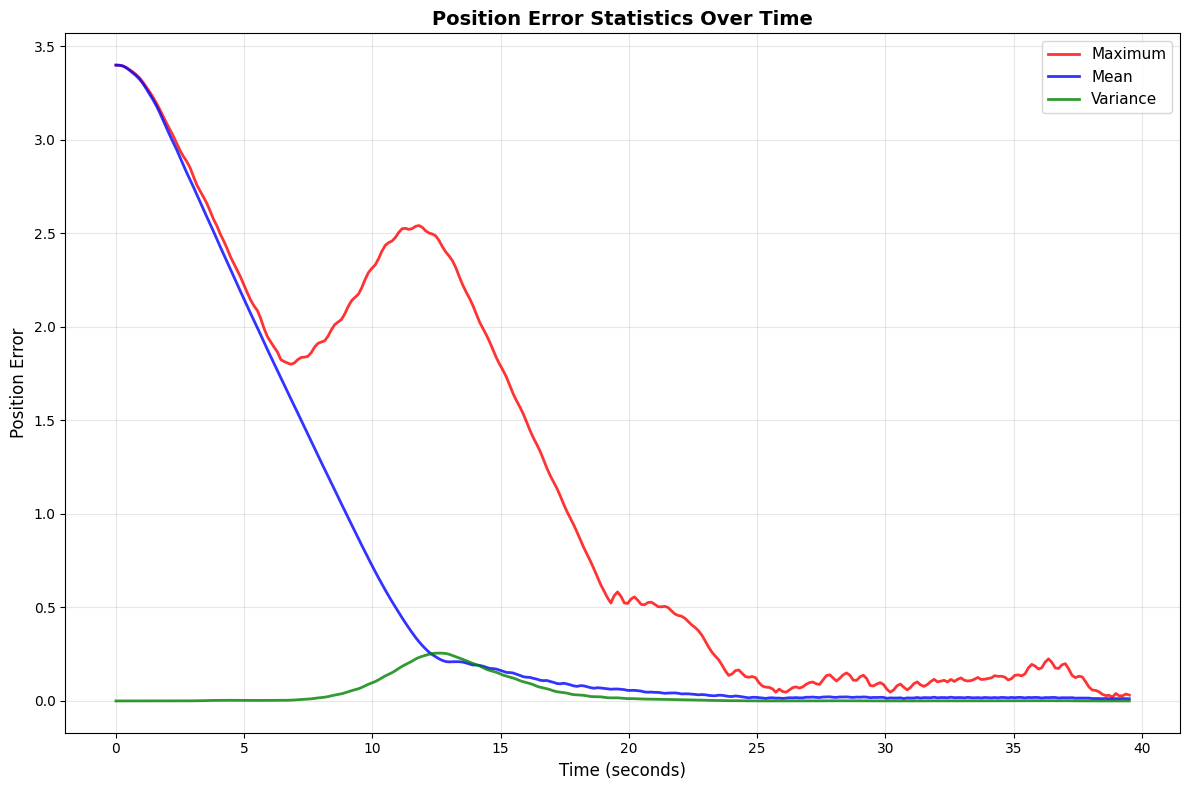

,tsec,max_pos_error,mean_pos_error,var_pos_error
0,0.00000,3.400000,3.400000,1.116358e-15
1,0.13125,3.399356,3.399281,4.033712e-10
2,0.26250,3.395968,3.395682,9.128529e-09
3,0.39375,3.387620,3.386537,7.338392e-08
4,0.52500,3.376384,3.373112,4.804632e-07
...,...,...,...,...
297,38.98125,0.039830,0.012176,4.576130e-05
298,39.11250,0.027256,0.012052,1.394106e-05
299,39.24375,0.027803,0.012742,2.604364e-05
300,39.37500,0.036838,0.012242,3.416755e-05


In [167]:
plot_pos_error_statistics(df_error)

In [211]:

def plot_pos_error_statistics_with_intervals(df,save=False):
    """
    Create a plot showing maximum and mean of pos_error as lines, and variance as vertical intervals.
    
    Args:
        df: DataFrame with columns ['tstep', 'tsec', 'agent', 'pos_error']
    """
    
    # Group by tsec and calculate statistics
    stats = df.groupby('tsec').agg({
        'pos_error': ['max', 'mean', 'var']
    }).reset_index()
    
    # Flatten column names
    stats.columns = ['tsec', 'max_pos_error', 'mean_pos_error', 'var_pos_error']
    
    # Calculate standard deviation for the intervals
    stats['std_pos_error'] = np.sqrt(stats['var_pos_error'])
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Plot maximum and mean as lines
    plt.plot(stats['tsec'], stats['max_pos_error'], 'r-', linewidth=2, label='Maximum', alpha=0.8)
    plt.plot(stats['tsec'], stats['mean_pos_error'], 'b-', linewidth=2, label='Mean', alpha=0.8)
    
    # Plot variance as vertical intervals (error bars)
    # We'll use the mean ± standard deviation to show the spread
    plt.errorbar(stats['tsec'], stats['mean_pos_error'], 
                yerr=stats['std_pos_error'], 
                fmt='none',  # Don't plot points, just error bars
                color='g', 
                alpha=0.6, 
                capsize=3, 
                capthick=1,
                label='±1 Std Dev')
    
    # Customize the plot
    n_robots = len(df_error.groupby('agent'))
    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('Position Error (meters)', fontsize=12)
    plt.title(f'N={n_robots}, Position Error Statistics Over Time\n(Mean ± Std Dev shown as vertical intervals)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    
    # Add some styling
    plt.tight_layout()
    if save:
        plt.savefig(f'pos_error_statistics_with_intervals.png')
    else:
        plt.show()
    # # Show the plot
    # plt.show()
    
    return stats



# Alternative version that shows the full range (min to max) as intervals
def plot_pos_error_statistics_with_range_intervals(df,save=False):
    """
    Create a plot showing mean as a line, and the full range (min to max) as vertical intervals.
    
    Args:
        df: DataFrame with columns ['tstep', 'tsec', 'agent', 'pos_error']
    """
    
    # Group by tsec and calculate statistics
    stats = df.groupby('tsec').agg({
        'pos_error': ['min', 'max', 'mean']
    }).reset_index()
    
    # Flatten column names
    stats.columns = ['tsec', 'min_pos_error', 'max_pos_error', 'mean_pos_error']
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Plot mean as a line
    plt.plot(stats['tsec'], stats['mean_pos_error'], 'b-', linewidth=2, label='Mean', alpha=0.8)
    
    # Plot the full range as vertical intervals
    n_robots = len(df_error.groupby('agent'))
    
    plt.errorbar(stats['tsec'], stats['mean_pos_error'], 
                yerr=[stats['mean_pos_error'] - stats['min_pos_error'], 
                      stats['max_pos_error'] - stats['mean_pos_error']], 
                fmt='none',  # Don't plot points, just error bars
                color='g', 
                alpha=0.6, 
                capsize=3, 
                capthick=1,
                label='Min to Max Range')
    
    # Customize the plot
    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('Position Error (meters)', fontsize=12)
    plt.title(f'N={n_robots}, Position Error Statistics Over Time\n(Mean with Min-Max Range shown as vertical intervals)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    
    # Add some styling
    plt.tight_layout()
    
    if save:
        plt.savefig(f'pos_error_statistics_with_range_intervals.png')
    else:
        plt.show()
    
    return stats

# Example usage:
# If your DataFrame is called 'df':
# stats = plot_pos_error_statistics_with_intervals(df)
# 
# # Or to save:
# stats = plot_pos_error_statistics_with_intervals_save(df, 'my_plot.png')
# 
# # Or for full range intervals:
# stats = plot_pos_error_statistics_with_range_intervals(df) 

,tsec,min_pos_error,max_pos_error,mean_pos_error
0,0.00000,3.400000,3.400000,3.400000
1,0.13125,3.399263,3.399356,3.399281
2,0.26250,3.395590,3.395968,3.395682
3,0.39375,3.386292,3.387620,3.386537
4,0.52500,3.372785,3.376384,3.373112
...,...,...,...,...
297,38.98125,0.004756,0.039830,0.012176
298,39.11250,0.009375,0.027256,0.012052
299,39.24375,0.007422,0.027803,0.012742
300,39.37500,0.003931,0.036838,0.012242


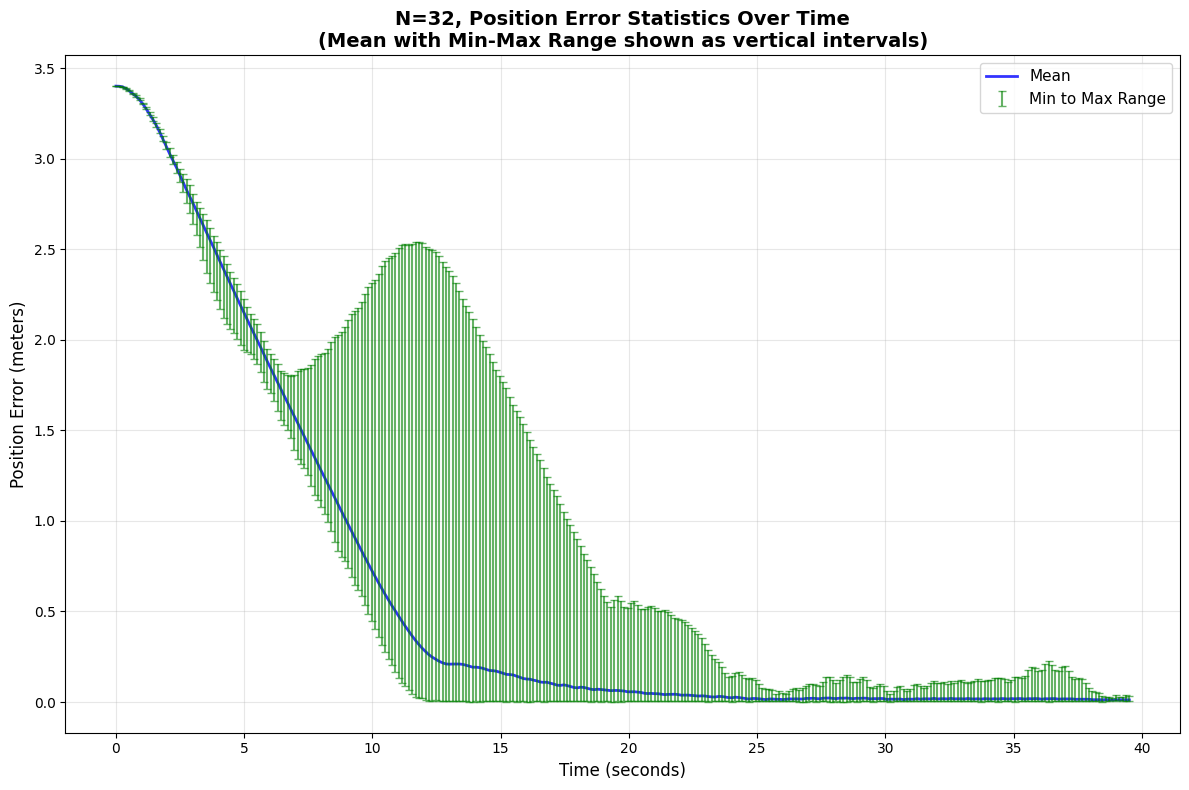

In [212]:
plot_pos_error_statistics_with_range_intervals(df_error,save=True)


,tsec,max_pos_error,mean_pos_error,var_pos_error,std_pos_error
0,35.04375,0.136878,0.017257,0.000762,0.027598
1,35.17500,0.139441,0.018999,0.000759,0.027558
2,35.30625,0.134020,0.018564,0.000659,0.025677
3,35.43750,0.144247,0.016237,0.000642,0.025343
4,35.56875,0.176345,0.018669,0.000916,0.030269
5,35.70000,0.195489,0.017796,0.001127,0.033569
6,35.83125,0.186579,0.018862,0.001010,0.031774
7,35.96250,0.170445,0.018272,0.000830,0.028813
8,36.09375,0.177256,0.015524,0.000877,0.029615
9,36.22500,0.207685,0.018101,0.001212,0.034810


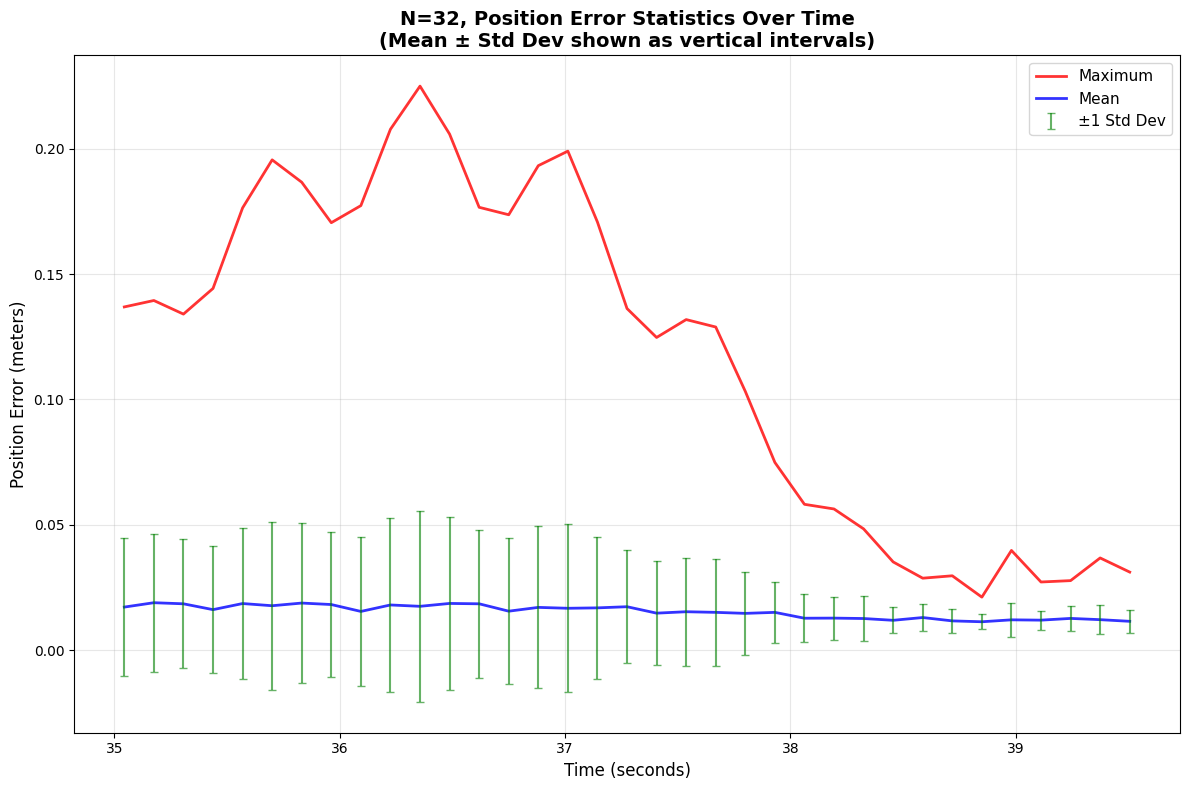

In [213]:
plot_pos_error_statistics_with_intervals(df_error[df_error['tsec'] >35],save=True)


In [190]:
df_error[df_error['tsec'] >35]['pos_error'].groupby(df_error['tsec']).max()

tsec
35.04375    0.136878
35.17500    0.139441
35.30625    0.134020
35.43750    0.144247
35.56875    0.176345
35.70000    0.195489
35.83125    0.186579
35.96250    0.170445
36.09375    0.177256
36.22500    0.207685
36.35625    0.224878
36.48750    0.205760
36.61875    0.176586
36.75000    0.173613
36.88125    0.193176
37.01250    0.198972
37.14375    0.170709
37.27500    0.136239
37.40625    0.124708
37.53750    0.131838
37.66875    0.128875
37.80000    0.103229
37.93125    0.074912
38.06250    0.058215
38.19375    0.056357
38.32500    0.048432
38.45625    0.035256
38.58750    0.028774
38.71875    0.029731
38.85000    0.021218
38.98125    0.039830
39.11250    0.027256
39.24375    0.027803
39.37500    0.036838
39.50625    0.031204
Name: pos_error, dtype: float64

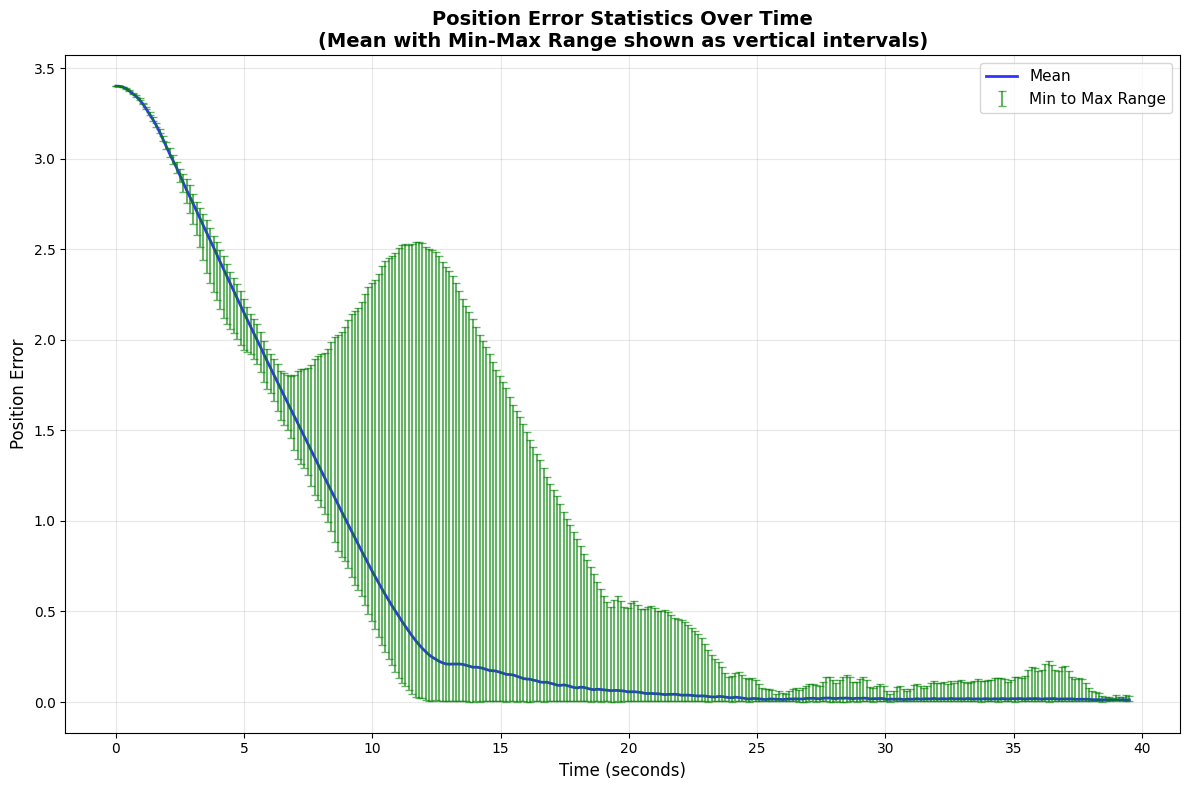

,tsec,min_pos_error,max_pos_error,mean_pos_error
0,0.00000,3.400000,3.400000,3.400000
1,0.13125,3.399263,3.399356,3.399281
2,0.26250,3.395590,3.395968,3.395682
3,0.39375,3.386292,3.387620,3.386537
4,0.52500,3.372785,3.376384,3.373112
...,...,...,...,...
297,38.98125,0.004756,0.039830,0.012176
298,39.11250,0.009375,0.027256,0.012052
299,39.24375,0.007422,0.027803,0.012742
300,39.37500,0.003931,0.036838,0.012242


In [174]:
plot_pos_error_statistics_with_range_intervals(df_error)

In [ ]:
df_contact_raw = pd.DataFrame(stats['contact'])


In [56]:
plt.show()
